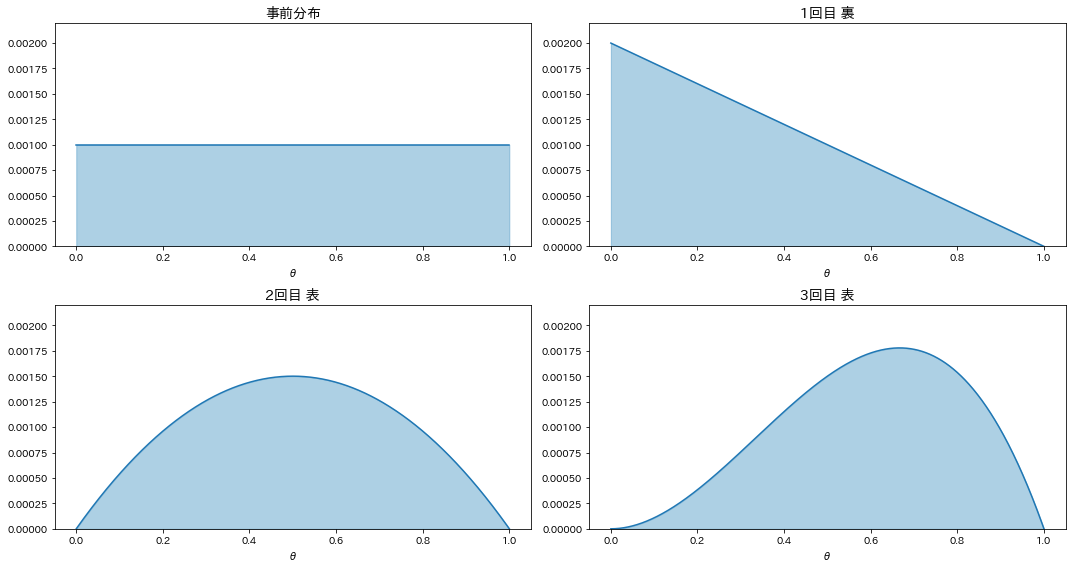

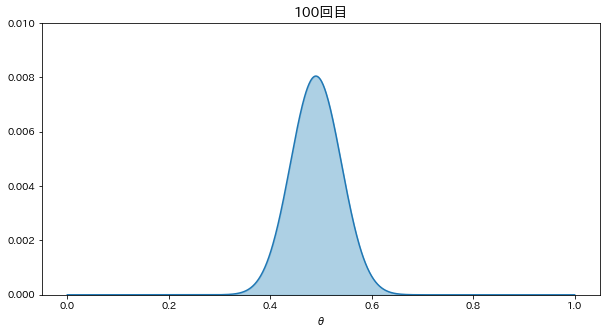

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy import stats

# パラメータ
thetas = np.linspace(0, 1, 1000)

# 尤度関数
likelihood = lambda x: thetas if x == 1 else (1-thetas)

# 事後分布
def posterior(r, prior):
    lp = likelihood(r) * prior
    return lp / lp.sum()

def plot(thetas, p, ax, title="", ylim=0.0022):
    ax.plot(thetas, p)
    ax.fill_between(thetas, 0, p, color="#348ABD", alpha=0.4)
    ax.set_ylim([0, ylim])
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(r'$\theta$');

# 事前分布
p = np.array([1 / len(thetas) for _ in thetas])

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.ravel()
plot(thetas, p, ax[0], "事前分布")

# コインが裏, 表, 表と出た
trials = [0, 1, 1]
for i, t in enumerate(trials):
    p = posterior(t, p)
    result = '表' if t == 1 else '裏'
    plot(thetas, p, ax[i+1], f"{i+1}回目 {result}")
fig.tight_layout()
fig.savefig("000.png", bbox_inches="tight")

# 真の表が出る確率を0.5として追加で97回投げる
trials = stats.bernoulli.rvs(0.5, size=97, random_state=42)
for i, t in enumerate(trials):
    p = posterior(t, p)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot(thetas, p, ax, "100回目", 0.01)
fig.savefig("001.png", bbox_inches="tight")

In [2]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
import pymc3 as pm
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# 真のCVR
true_p_A = 0.05
true_p_B = 0.04

# ユーザ数
N_A = 1000
N_B = 1000

# サンプルデータ
sample_A = stats.bernoulli.rvs(true_p_A, size=N_A, random_state=1225)
sample_B = stats.bernoulli.rvs(true_p_B, size=N_B, random_state=1226)
print(f"(A) 購入人数={sample_A.sum()} / 観測されたCVR={sample_A.sum() / len(sample_A)}")
print(f"(B) 購入人数={sample_B.sum()} / 観測されたCVR={sample_B.sum() / len(sample_B)}")

(A) 購入人数=57 / 観測されたCVR=0.057
(B) 購入人数=48 / 観測されたCVR=0.048


In [4]:
with pm.Model() as model:
    # 事前分布は一様分布
    p_A = pm.Uniform("$p_A$", lower=0, upper=1)
    p_B = pm.Uniform("$p_B$", lower=0, upper=1)
    # AとBのCVRの差
    delta = pm.Deterministic("delta", p_A - p_B)
    # 尤度関数はベルヌーイ分布
    obs_A = pm.Bernoulli("obs_A", p_A, observed=sample_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=sample_B)
    # 事後分布をサンプリング
    trace = pm.sample(20000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 17 seconds.


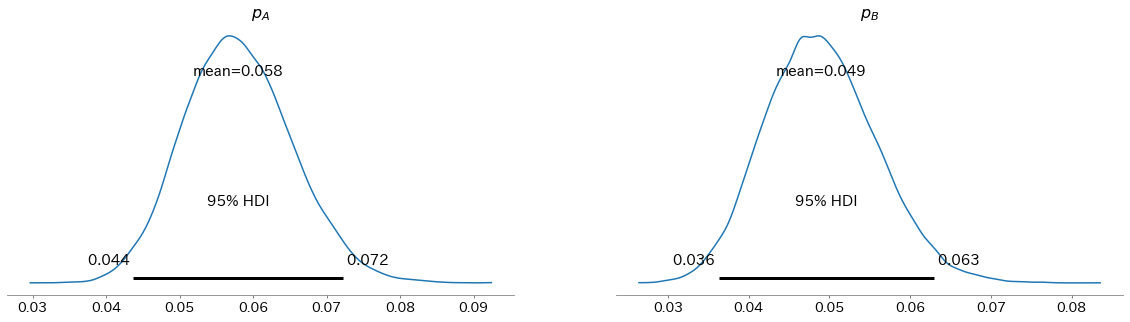

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
with model:
    pm.plot_posterior(trace, var_names="$p_A$", hdi_prob=0.95, ax=ax[0])
    pm.plot_posterior(trace, var_names="$p_B$", hdi_prob=0.95, ax=ax[1])
fig.savefig("002.png", bbox_inches="tight")

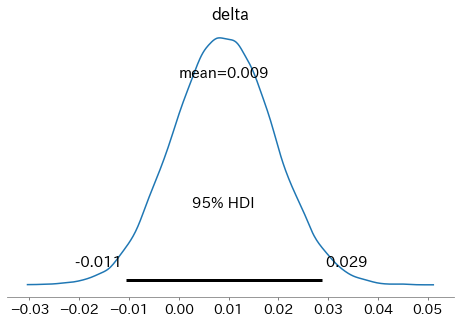

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
with model:
    pm.plot_posterior(trace, var_names="delta", hdi_prob=0.95, ax=ax)
fig.savefig("003.png", bbox_inches="tight")

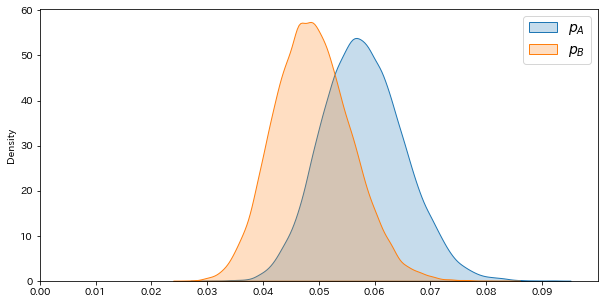

In [7]:
plt.figure(figsize=(10, 5))
sns.kdeplot(trace["$p_A$"], label="$p_A$", fill=True)
sns.kdeplot(trace["$p_B$"], label="$p_B$", fill=True)
plt.xlim([0, 0.1])
plt.xticks([i / 100 for i in range(10)])
plt.legend(fontsize=14)
plt.savefig("004.png", bbox_inches="tight")

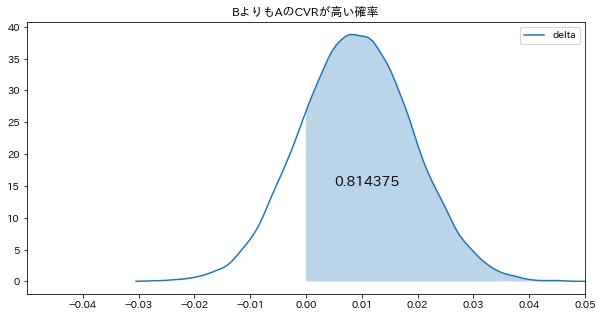

In [8]:
plt.figure(figsize=(10, 5))
dist = trace["delta"]
kde = stats.gaussian_kde(dist)
pos = np.linspace(dist.min(), dist.max(), 101)
plt.plot(pos, kde(pos), label="delta")
shade = np.linspace(0, dist.max(), 101)
plt.fill_between(shade, kde(shade), alpha=0.3)
plt.xticks([(-4 + i) / 100 for i in range(10)])
s = pm.summary(trace, var_names=["delta"], hdi_prob=0.95, round_to=4)
min = s["hdi_2.5%"].values[0]
max = s["hdi_97.5%"].values[0]
plt.text(x=0.005, y=15, s=np.mean(trace['delta'] > 0), fontdict={"fontsize": 14})
plt.xlim([-0.05, 0.05])
plt.legend()
plt.title("BよりもAのCVRが高い確率")
plt.savefig("005.png", bbox_inches="tight");

In [9]:
# 信頼区間
def confidence_interval(sample_A, sample_B):
    n1 = len(sample_A)
    n2 = len(sample_B)
    p1 = sample_A.sum() / len(sample_A)
    p2 = sample_B.sum() / len(sample_B)
    z = 1.96
    return np.round((p1 - p2) - z*math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2), 5), np.round((p1 - p2) + z*math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2), 5)

n_samples = np.arange(500, 10500, 500)
traces = []
hdis = []
better_A_probs = []
confidence_intervals = []
for i, n in enumerate(n_samples):
    print(n, i)
    true_p_A = 0.05
    true_p_B = 0.04
    N_A = n
    N_B = n
    sample_A = stats.bernoulli.rvs(true_p_A, size=N_A, random_state=1225)
    sample_B = stats.bernoulli.rvs(true_p_B, size=N_B, random_state=1226)
    with pm.Model() as model:
        p_A = pm.Uniform("$p_A$", lower=0, upper=1)
        p_B = pm.Uniform("$p_B$", lower=0, upper=1)
        delta = pm.Deterministic("delta", p_A - p_B)
        obs_A = pm.Bernoulli("obs_A", p_A, observed=sample_A)
        obs_B = pm.Bernoulli("obs_B", p_B, observed=sample_B)
        trace = pm.sample(20000, random_seed=42)
        traces.append(trace)
        d = pm.summary(trace, hdi_prob=0.95).loc["delta"]
        hdis.append((d["hdi_2.5%"], d["hdi_97.5%"]))
        better_A_probs.append(np.mean(trace['delta'] > 0))
        confidence_intervals.append(confidence_interval(sample_A, sample_B))

500 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 22 seconds.


1000 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 23 seconds.


1500 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 21 seconds.


2000 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 24 seconds.


2500 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 23 seconds.


3000 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 27 seconds.


3500 6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 24 seconds.


4000 7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 26 seconds.


4500 8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 26 seconds.


5000 9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 20 seconds.


5500 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 27 seconds.


6000 11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 27 seconds.


6500 12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 29 seconds.


7000 13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 27 seconds.


7500 14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 29 seconds.


8000 15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 38 seconds.


8500 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 34 seconds.


9000 17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 35 seconds.


9500 18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 40 seconds.


10000 19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 34 seconds.


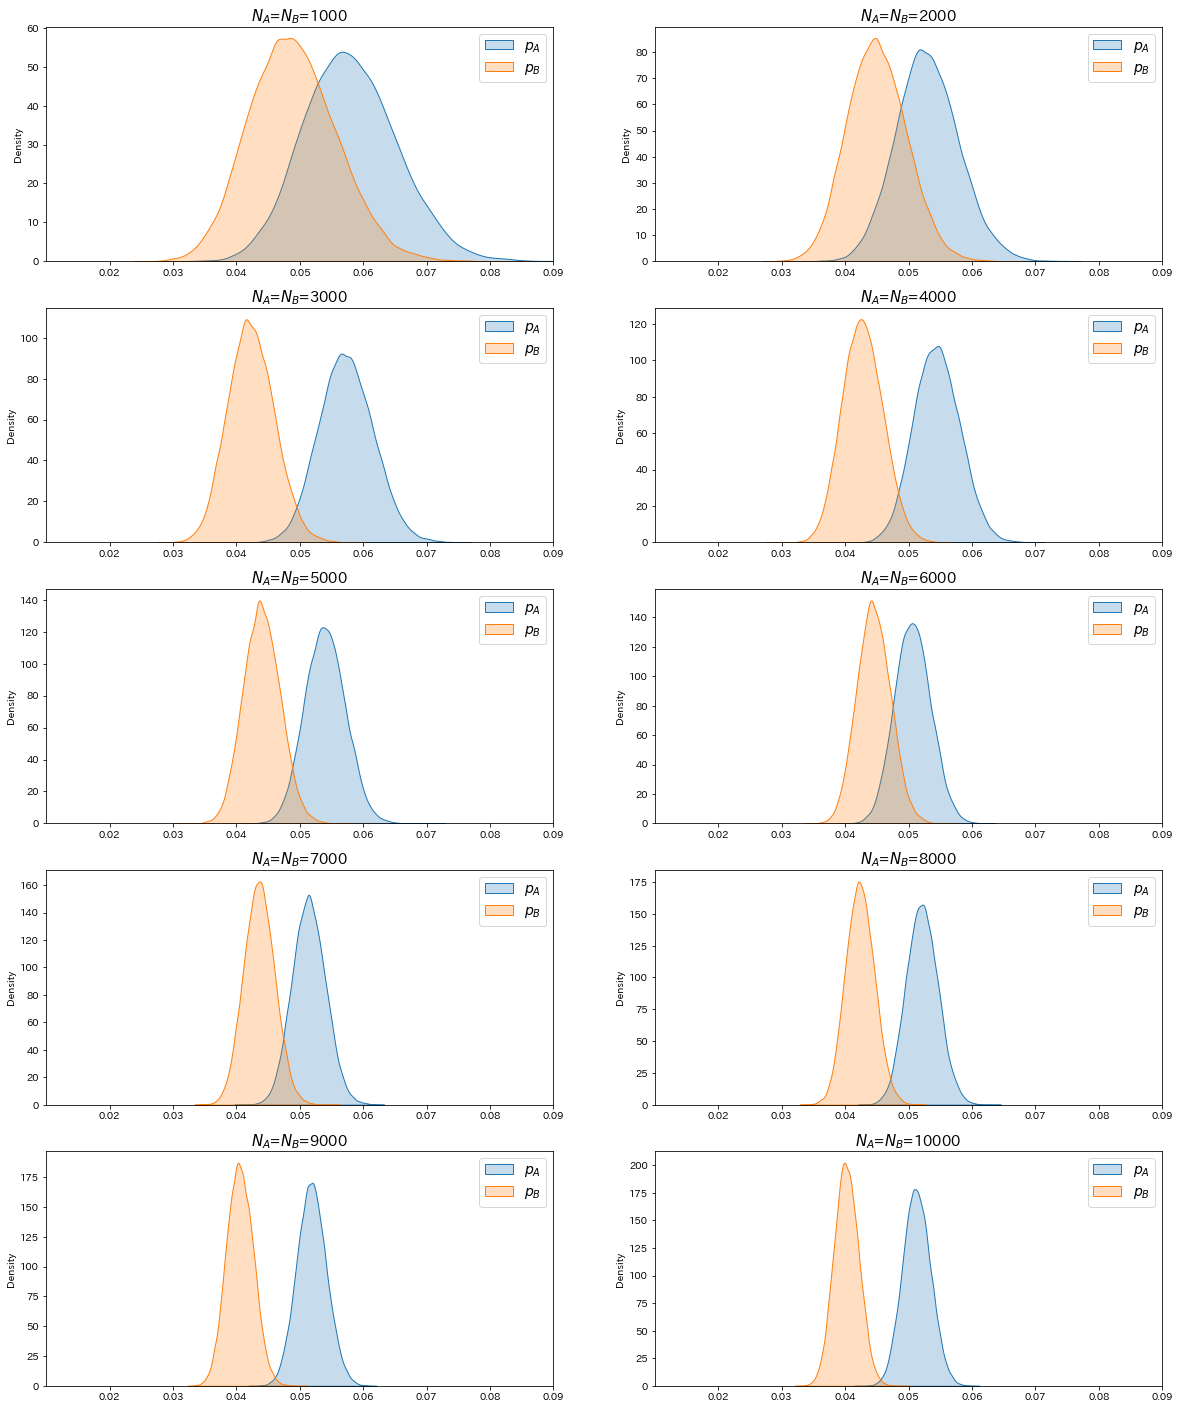

In [11]:
plt.figure(figsize=(20, 25))
j = 0
for i, n in enumerate(n_samples):
    if n % 1000 != 0:
        continue
    plt.subplot(5, 2, j+1)
    trace = traces[i]    
    sns.kdeplot(trace["$p_A$"], label="$p_A$", fill=True)
    sns.kdeplot(trace["$p_B$"], label="$p_B$", fill=True)
    plt.xlim([0.01, 0.08])
    plt.xticks(np.arange(0.02, 0.1, 0.01))
    plt.title(f"$N_A$=$N_B$={n}", fontsize=15)
    plt.legend(fontsize=14)
    j += 1
plt.savefig("006.png", bbox_inches="tight")

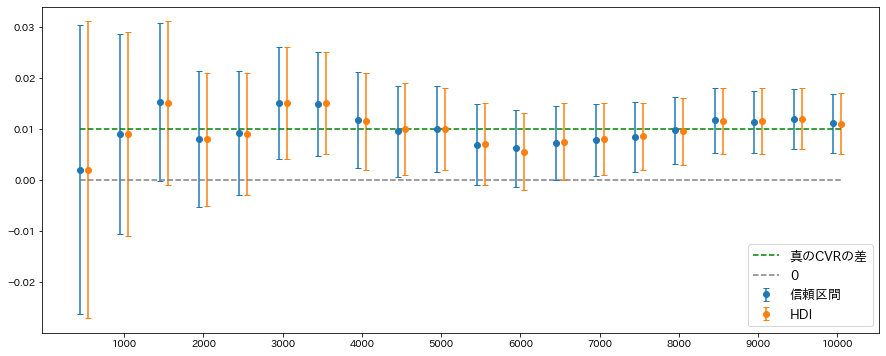

In [19]:
import random

y_list = [(interval[0] + interval[1]) / 2 for interval in confidence_intervals]
data_1 = {
    'x': n_samples-50,
    'y': y_list,
    'yerr': [(interval[1] - y) for interval, y in zip(confidence_intervals, y_list)],
    'label': '信頼区間'}

y_list = [(interval[0] + interval[1]) / 2 for interval in hdis]
data_2 = {
    'x': n_samples+50,
    'y': y_list,
    'yerr': [(interval[1] - y) for interval, y in zip(hdis, y_list)],
    'label': 'HDI'
}

plt.figure(figsize=(15, 6))
for data in [data_1, data_2]:
    plt.errorbar(**data, fmt='o', capsize=3, capthick=1)
    data = {
        'x': data['x'],
        'y1': [y - e for y, e in zip(data['y'], data['yerr'])],
        'y2': [y + e for y, e in zip(data['y'], data['yerr'])]}
plt.hlines(0.01, 450, 10050, linestyles="--", color="green", label="真のCVRの差")
plt.hlines(0.0, 450, 10050, linestyles="--", color="gray", label="0")
plt.legend(fontsize=13)
plt.xticks(np.arange(1000, 11000, 1000))
plt.savefig("007.png", bbox_inches="tight")

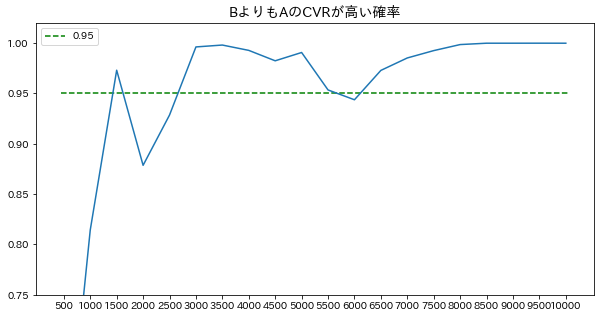

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(n_samples, better_A_probs)
plt.xticks(n_samples)
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.hlines(0.95, 450, 10050, linestyles="--", color="green", label="0.95")
plt.title("BよりもAのCVRが高い確率", fontsize=14)
plt.ylim(0.75, 1.02)
plt.legend()
plt.savefig("008.png", bbox_inches="tight")

In [24]:
# 信頼区間
def confidence_interval(sample_A, sample_B):
    n1 = len(sample_A)
    n2 = len(sample_B)
    p1 = sample_A.sum() / len(sample_A)
    p2 = sample_B.sum() / len(sample_B)
    z = 1.96
    return np.round((p1 - p2) - z*math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2), 5), np.round((p1 - p2) + z*math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2), 5)

n_samples = np.arange(500, 10500, 500)
traces = []
hdis = []
better_A_probs = []
confidence_intervals = []
for i, n in enumerate(n_samples):
    print(n, i)
    true_p_A = 0.05
    true_p_B = 0.05
    N_A = n
    N_B = n
    sample_A = stats.bernoulli.rvs(true_p_A, size=N_A, random_state=1225)
    sample_B = stats.bernoulli.rvs(true_p_B, size=N_B, random_state=1226)
    with pm.Model() as model:
        p_A = pm.Uniform("$p_A$", lower=0, upper=1)
        p_B = pm.Uniform("$p_B$", lower=0, upper=1)
        delta = pm.Deterministic("delta", p_A - p_B)
        obs_A = pm.Bernoulli("obs_A", p_A, observed=sample_A)
        obs_B = pm.Bernoulli("obs_B", p_B, observed=sample_B)
        trace = pm.sample(20000, random_seed=42)
        traces.append(trace)
        d = pm.summary(trace, hdi_prob=0.95).loc["delta"]
        hdis.append((d["hdi_2.5%"], d["hdi_97.5%"]))
        better_A_probs.append(np.mean(trace['delta'] > 0))
        confidence_intervals.append(confidence_interval(sample_A, sample_B))

500 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 20 seconds.


1000 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 20 seconds.


1500 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 19 seconds.


2000 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 21 seconds.


2500 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 22 seconds.


3000 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 23 seconds.


3500 6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 24 seconds.


4000 7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 23 seconds.


4500 8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 22 seconds.


5000 9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 25 seconds.


5500 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 25 seconds.


6000 11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 25 seconds.


6500 12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 24 seconds.


7000 13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 26 seconds.


7500 14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 27 seconds.


8000 15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 28 seconds.


8500 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 30 seconds.


9000 17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 31 seconds.


9500 18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 30 seconds.


10000 19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [$p_B$, $p_A$]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 30 seconds.


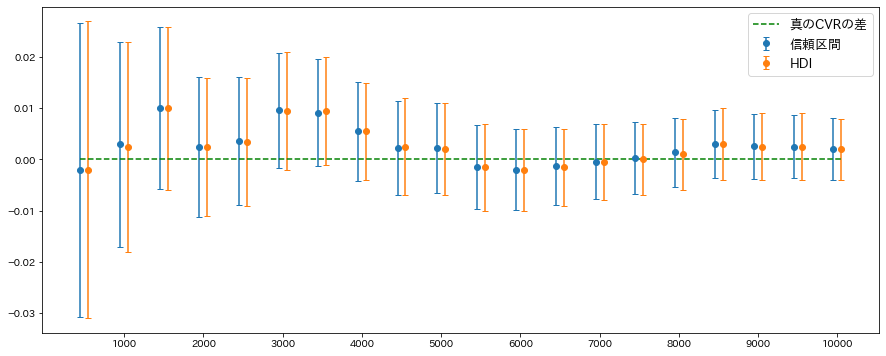

In [34]:
import random

y_list = [(interval[0] + interval[1]) / 2 for interval in confidence_intervals]
data_1 = {
    'x': n_samples-50,
    'y': y_list,
    'yerr': [(interval[1] - y) for interval, y in zip(confidence_intervals, y_list)],
    'label': '信頼区間'}

y_list = [(interval[0] + interval[1]) / 2 for interval in hdis]
data_2 = {
    'x': n_samples+50,
    'y': y_list,
    'yerr': [(interval[1] - y) for interval, y in zip(hdis, y_list)],
    'label': 'HDI'
}

plt.figure(figsize=(15, 6))
for data in [data_1, data_2]:
    plt.errorbar(**data, fmt='o', capsize=3, capthick=1)
    data = {
        'x': data['x'],
        'y1': [y - e for y, e in zip(data['y'], data['yerr'])],
        'y2': [y + e for y, e in zip(data['y'], data['yerr'])]}
plt.hlines(0.0, 450, 10050, linestyles="--", color="green", label="真のCVRの差")
plt.legend(fontsize=13)
plt.xticks(np.arange(1000, 11000, 1000))
plt.savefig("009.png", bbox_inches="tight")

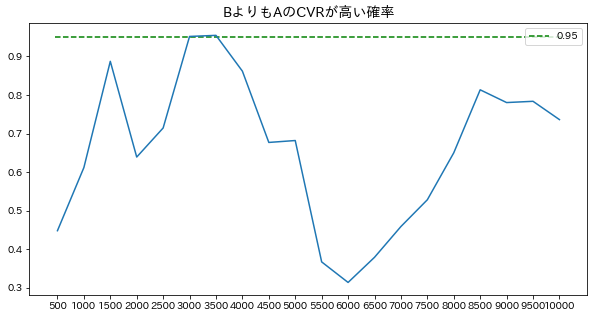

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(n_samples, better_A_probs)
plt.xticks(n_samples)
# plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.hlines(0.95, 450, 10050, linestyles="--", color="green", label="0.95")
plt.title("BよりもAのCVRが高い確率", fontsize=14)
# plt.ylim(0.75, 1.02)
plt.legend();
plt.savefig("010.png", bbox_inches="tight")